In [1]:
import requests
import pprint

# respuesta = requests.get("https://covid19.isciii.es/")
respuesta = requests.get("https://zerjio.com/temp/covid19.html")  # Utilizamo el metodo GET del protocolor HTTP

html = respuesta.content.decode("UTF-8")

# busquemos una fecha para empezar, analizando el codigo de la web, a lo burro

cadena_buscada = '<span id="fecha">'
pos_inicial = html.find(cadena_buscada) + len(cadena_buscada)
pos_final = html.find('</span>', pos_inicial)

fecha = html[pos_inicial:pos_final]

print(fecha)
# podemos hacer lo mismo con la hora


10 de Marzo de 2020


In [2]:
# usando expresiones regulares 
import regex as re

fecha = re.search(r'<span id="fecha">(.*)</span>', html).group(1)
hora = re.search(r'<span id="hora">(.*)</span>', html).group(1)

print("%s - %s" % (fecha, hora))

10 de Marzo de 2020 - 10:10


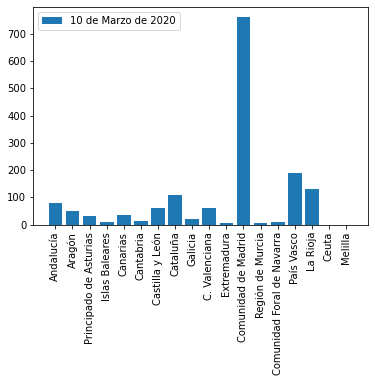

In [5]:
# En este ejemplo vamos a usar el etree sax parser para obtener la información de la tabla que hay en la página 
# sobre 
from lxml import etree
from io import StringIO, BytesIO
import numpy as np
import matplotlib.pyplot as plt


class ParseCOVID():             # Manejadores de eventos
    tablaComenzada = False
    
    ultimaEtiquetaLeida = ""
    
    datosColumnas = []
    
    columnaActual = 0
    filaActual = -1
    
    def __init__(self):           # Este método se ejecuta al principio de parsear el documento
        return

    def start(self, tag, attrib): # Este método se ejecuta cuando aparece la apertura de una etiqueta
        if (tag == '{http://www.w3.org/1999/xhtml}th'):
            self.datosColumnas += [[]]  # inicializamos el array de cada columna
        
                    
        elif (tag == '{http://www.w3.org/1999/xhtml}tr') and (self.tablaComenzada == True):
            self.columnaActual = -1  # Empezamos a leer la siguiente fila
            self.filaActual += 1
            
        elif (tag == '{http://www.w3.org/1999/xhtml}td') and (self.tablaComenzada == True):
            self.columnaActual += 1
            self.datosColumnas[self.columnaActual].append("")  # Inicializamos el dato nuevo
            
        self.ultimaEtiquetaLeida = tag

    def end(self, tag):           # Este método se ejecuta cuando aparece el cierre de una etiqueta
        if (tag == '{http://www.w3.org/1999/xhtml}thead'):
            self.tablaComenzada = True



    def data(self, data):         # Este método se ejecuta con el contenido de una etiqueta
        if (self.ultimaEtiquetaLeida == '{http://www.w3.org/1999/xhtml}td') and (self.tablaComenzada == True):
            
            self.datosColumnas[self.columnaActual][self.filaActual] += data


    def close(self):              # Este método se ejecuta al final del archivo
        return
        
        
    def getColumns(self):    
        return self.datosColumnas
    
# Creamos el objeto analizador (de la clase de más arriba), creamos un parser con él y le decimos 
# a la biblioteca lmxl.etree que parsee el documento HTML con este tipo de parser SAX
analizador = ParseCOVID()
parser = etree.XMLParser(target=analizador, recover=True)
etree.parse(StringIO(html), parser)


# Obtenemos la información sacada de la tabla
datosColumnas = analizador.getColumns()
comunidades = datosColumnas[0]
casos = datosColumnas[1]

# Quitamos caracteres extraños a los nombres de las comunidades
comunidades[:] = [n.strip() for n in comunidades]

# Convertimos a entero los datos numericos (quitando caracteres extraños)
casos[:] = [int(d.strip()) for d in casos]


# Creamos el gráfico de barras
plt.bar(comunidades, casos, label=fecha)
# Rotation of the bars names
plt.xticks(rotation=90)
plt.legend() #show labels
# Show graphic
plt.show()


In [14]:
# PARSERS DOM
# html podria funcionar, se puede probar, en principio cogemos una xml para asegurarnos que el codigo funciona
import xml.dom.minidom
import regex as re

url = 'http://ep00.epimg.net/rss/tags/ultimas_noticias.xml'
rss = requests.get(url).content.decode("UTF-8") # obtenemos la pagina directamente

dom = xml.dom.minidom.parseString(rss) # analiza la web

# Obtenemos todas las etiquetas "item", cada noticia esta en una etiqueta item <item> noticia </item>
items = dom.getElementsByTagName("item")

# fecha_noticias = re.search(r'<lastBuildDate>', xml).group(1)
# hora_noticias = re.search(r'</lastBuildDate>', xml).group(1)

# print("%s - %s" % (fecha_noticias, hora_noticias))
# Para cada etiqueta mostraremos el título de la noticia asociada y la url de la imagen asociada (si la tiene)
for item in items:
    titulo = item.getElementsByTagName("title")
    
    print(" + " + titulo[0].firstChild.nodeValue)   # Detalle "peliagudo", el texto de dentro de una etiqueta 
                                                    # es considerado un hijo. De hecho una etiqueta puede tener
                                                    # varios hijos de "texto". Ejemplo:
                                                    # <etiquetaConTexto>
                                                    #   Esto es texto
                                                    #   <etiquetaHijo />
                                                    #   Más texto
                                                    # </etiquetaConTexto>
                                                    #
                                                    # El elemento "etiquetaConTexto" tiene tres hijos:
                                                    #    + Hijo 1: de tipo texto: "\n  Esto es texto\n  "
                                                    #    + Hijo 2: etiqueta "etiquetaHijo"
                                                    #    + Hijo 3: de tipo texto: "\n  Más text\n  "

# En este ejemplo, las urls de las imágenes asociadas a un item están en la etiqueta "enclosure", atributo "url":

    enclosures = item.getElementsByTagName("enclosure")
    
    for e in enclosures:
        print("   - " + e.getAttribute('url'))

 + Tabasco, al límite por la epidemia del coronavirus
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/album/1595286872_974013_1595287106_miniatura_normal.jpg
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/album/1595286872_974013_1595287105_noticia_normal.jpg
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/album/1595286872_974013_1595287106_noticia_grande.jpg
 + El ladrón que se aficionó a robar ropa interior de una vecina de Conil
   - https://ep00.epimg.net/politica/imagenes/2020/07/21/diario_de_espana/1595348782_878557_1595349095_miniatura_normal.jpg
   - https://ep00.epimg.net/politica/imagenes/2020/07/21/diario_de_espana/1595348782_878557_1595349095_noticia_normal.jpg
 + Carlsen: raro pero muy eficaz
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/media/1595335882_565428_1595348984_miniatura_normal.jpg
 + Coronavirus: las imágenes de la pandemia en el mundo, 21-07-2020
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/album/1595321366_900159_159533

In [15]:
# Repetimos el ejercicio anterior pero con el parser DOM lxml.etree
from lxml import etree

tree = etree.parse(url)

raiz = tree.getroot()

# Iteramos por todos los descendientes de raiz que sean "item"

for item in raiz.iter("item"):
    for hijo in item.iter("title"):
        print(" + " + hijo.text)
    
    for hijo in item.iter("enclosure"):
        print("   - " + hijo.attrib['url'])
    

 + Tabasco, al límite por la epidemia del coronavirus
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/album/1595286872_974013_1595287106_miniatura_normal.jpg
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/album/1595286872_974013_1595287105_noticia_normal.jpg
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/album/1595286872_974013_1595287106_noticia_grande.jpg
 + El ladrón que se aficionó a robar ropa interior de una vecina de Conil
   - https://ep00.epimg.net/politica/imagenes/2020/07/21/diario_de_espana/1595348782_878557_1595349095_miniatura_normal.jpg
   - https://ep00.epimg.net/politica/imagenes/2020/07/21/diario_de_espana/1595348782_878557_1595349095_noticia_normal.jpg
 + Carlsen: raro pero muy eficaz
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/media/1595335882_565428_1595348984_miniatura_normal.jpg
 + Coronavirus: las imágenes de la pandemia en el mundo, 21-07-2020
   - https://ep00.epimg.net/elpais/imagenes/2020/07/21/album/1595321366_900159_159533

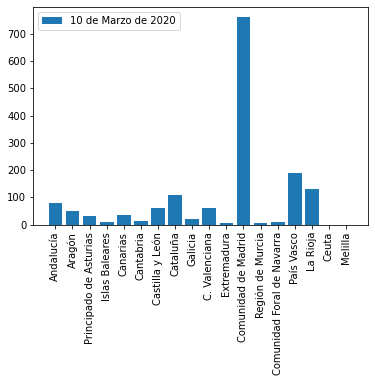

In [16]:
# Replicaremos el ejemplo de la gráfica de casos de COVID-19 de manera mucho más simple
from lxml import etree
from io import StringIO, BytesIO
import matplotlib.pyplot as plt

parserHTML = etree.HTMLParser()

# Recuerda que html se inicializó mucho antes con el contenido de la página https://covid19.isciii.es/
tree = etree.parse(StringIO(html), parserHTML)

#usando la funcion xpath, que busca los elementos 
tablas = tree.xpath('//table')  # Nos devuelve todos los elementos "table" en cualquier sitio del documento
                                # En nuestro caso habrá devuelto 2 tablas

# Nos interesa la segunda tabla de la página 
tabla = tablas[1]

comunidades = []
casos = []

filas = tabla.xpath('tbody/tr')  # Buscamos todos los <tr> que estén dentro de <tbody> en la tabla

for f in filas:
    comunidades.append(f[0].text)
    casos.append(int(f[1].text))
    
    
# Creamos el gráfico de barras
plt.bar(comunidades, casos, label=fecha)
# Rotation of the bars names
plt.xticks(rotation=90)
plt.legend()
# Show graphic
plt.show()